# Almgren-Chriss Framework – Quadratic Execution Costs

## Objective
Implement the **original Almgren-Chriss (2001)** optimal execution model in its **simplest and most elegant form**:
- **Quadratic execution costs**: $ L(\rho) = \eta \rho^2 $, where $ \rho = \frac{|v_t|}{V} $
- **Constant market volume** $ V $
- **Closed-form analytical solution** using hyperbolic functions

This notebook serves as:
- **Validation** of the theoretical implementation
- **Benchmark** for more realistic extensions
- **Illustration** of the foundational result in optimal liquidation

---

## Model (Almgren-Chriss, 2001)

### Price Dynamics (with Permanent Impact)
$$
dS_t = \sigma \, dW_t + b \, v_t \, dt
$$
> $ v_t = \dot{q}_t $: trading speed (shares/day)  
> $ b $: permanent impact coefficient  
> $ \sigma $: annualized volatility

### Execution Costs (Temporary / Instantaneous Impact)
$$
L(\rho) = \eta \rho^2, \quad \rho_t = \frac{|v_t|}{V}
\quad \Rightarrow \quad
\text{Execution cost over } [t, t+dt] = V \cdot L(\rho_t) \, dt = \eta \frac{v_t^2}{V} \, dt
$$

### Cash Process (for Liquidation, $ q_0 > 0 $)
$$
dX_t = - S_t \, v_t \, dt - \eta \frac{v_t^2}{V} \, dt
$$
> For **building a position** ($ q_0 < 0 $), signs reverse accordingly.

---

### Optimization Objective
Minimize the **risk-adjusted expected implementation shortfall**:
$$
\min_{v_t} \quad \mathbb{E}\left[ X_T \right] + \frac{\lambda}{2} \operatorname{Var}\left[ X_T \right]
$$
> $ \lambda $: risk aversion parameter  
> $ X_T $: final cash after unwinding $ q_0 \to 0 $ over $ [0, T] $

---

### Optimal Trajectory (Closed-Form Solution)
$$
\boxed{
q^*(t) = q_0 \frac{\sinh \left( \kappa (T - t) \right)}{\sinh (\kappa T)}
}
\quad \text{with} \quad
\boxed{
\kappa = \sqrt{\frac{\lambda \sigma^2 V}{2 \eta}}
}
$$

> $ v^*(t) = \dot{q}^*(t) $: optimal trading speed  
> Fast front-loading, then slowing down — elegant trade-off between **cost** and **risk**

---

## Inputs (for Practical Illustration)
- Market data: `data/processed/market_data_intraday.parquet`
  - Extract $ \sigma $ (annualized volatility)
  - Extract $ V $ (average daily volume)
- Execution scenario: $ q_0 = 200,000 $ shares, $ T = 1 $ day

## Outputs
- Optimal trading curve $ q^*(t) $, $ v^*(t) $
- Comparison with **TWAP** (constant speed)
- Cost breakdown: execution, permanent impact, timing risk
- Implementation shortfall in € and bps

In [1]:
# Imports standards
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
import warnings
warnings.filterwarnings('ignore')

# Configuration graphiques
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("✅ Imports réussis")

✅ Imports réussis


In [2]:
# Chargement des données de marché

df_market = pd.read_parquet('data/processed/market_data_intraday.parquet')

# Sélectionner un ticker
TICKER = 'AAPL'
data_ticker = df_market[df_market['ticker'] == TICKER]

print(f"📊 Données chargées pour {TICKER}")
print(f"   Période : {data_ticker.index.min()} → {data_ticker.index.max()}")
print(f"   Nombre de lignes : {len(data_ticker):,}")

📊 Données chargées pour AAPL
   Période : 2025-01-02 14:30:00+00:00 → 2025-06-27 19:59:00+00:00
   Nombre de lignes : 47,190


In [3]:
# PARAMETERS FROM MARKET DATA
df_params = pd.read_parquet('data/processed/market_parameters.parquet')
params = df_params[df_params['ticker'] == TICKER].iloc[0]

sigma = params['vol_annual']  # Volatility σ
V = params['volume_per_day']  # Constant market volume

print(f"✅ Parameters loaded for {TICKER}:")
print(f"   σ = {sigma:.4f}")
print(f"   V = {V:,.0f} shares/day")

# LITERATURE PARAMETERS
b = 0.0025  # Permanent impact parameter
eta = 0.10  # Execution cost coefficient for L(ρ) = η ρ²

# RISK AVERSION
lambda_risk = 5e-6  

# EXECUTION SCENARIO (Unwinding q0 over T)
q0 = 200_000  # Initial position (shares; >0 for liquidation/selling)
T = 1.0       # Horizon (days)
S0 = data_ticker['close'].iloc[-1]  # Initial price (for shortfall calc)

print(f"\n🎯 Execution scenario (unwinding to q_T=0):")
print(f"   q₀ = {q0:,} shares")
print(f"   T  = {T} day ({int(T*390)} minutes)")
print(f"   S₀ = {S0:.2f}")
print(f"   Notional = {abs(q0)*S0:,.0f}")

print("\n" + "="*70 + "\n")

# SUMMARY
params = {
    'sigma': sigma,
    'V': V,
    'b': b,  # Permanent
    'eta': eta,  # Temporary
    'lambda_risk': lambda_risk,
    'q0': q0,
    'T': T,
    'S0': S0
}
print("\n📋 Résumé des paramètres :")
for key, val in params.items():
    if isinstance(val, float) and val < 0.01:
        print(f"   {key:8s} = {val:.6f}")
    elif isinstance(val, float):
        print(f"   {key:8s} = {val:,.2f}")
    else:
        print(f"   {key:8s} = {val:,}")

✅ Parameters loaded for AAPL:
   σ = 0.3992
   V = 10,782,696 shares/day

🎯 Execution scenario (unwinding to q_T=0):
   q₀ = 200,000 shares
   T  = 1.0 day (390 minutes)
   S₀ = 201.10
   Notional = 40,220,000



📋 Résumé des paramètres :
   sigma    = 0.40
   V        = 10,782,696.04
   b        = 0.002500
   eta      = 0.10
   lambda_risk = 0.000005
   q0       = 200,000
   T        = 1.00
   S0       = 201.10


In [4]:
class AlmgrenChrissQuadratic:
    """
    Almgren-Chriss (2001) optimal execution model - Quadratic execution costs.
    
    Assumptions :
    - Quadratic costs: L(ρ) = η ρ² where ρ = |v|/V (participation rate)
    - Constant market volume V
    - Permanent impact: linear in v
    - Closed-form solution available
    
    Reference: Gueant, Chapter 3 (generalized from Almgren-Chriss [8,9])
    """
    
    def __init__(self, 
                 lambda_risk: float,  # Risk aversion λ
                 sigma: float,        # Volatility
                 b: float,            # Permanent impact
                 eta: float,          # Execution cost coeff
                 V: float):           # Market volume
        
        self.lambda_risk = lambda_risk
        self.sigma = sigma
        self.b = b
        self.eta = eta
        self.V = V
    
    def compute_kappa(self):
        """
        κ = √(λ σ² V / (2 η))
        Controls curvature of optimal trajectory.
        """
        kappa = np.sqrt(self.lambda_risk * self.sigma**2 * self.V / (2 * self.eta))
        return kappa
    
    def optimal_trajectory(self, 
                           q0: float, 
                           T: float, 
                           N: int = 390) -> tuple:
        """
        Optimal trajectory (closed-form).
        
        q*(t) = q0 * sinh(κ (T-t)) / sinh(κ T)
        
        v*(t) = dq/dt  (positive for buying if q0<0; negative for selling if q0>0)
        
        Parameters:
        - q0: Initial position (can be negative for building from short)
        - T: Horizon (days)
        - N: Time steps (390 for one trading day)
        
        Returns: t, q_star, v_star
        """
        
        kappa = self.compute_kappa()
        
        t = np.linspace(0, T, N+1)
        
        # Position: General for buy/sell
        q_star = q0 * np.sinh(kappa * (T - t)) / np.sinh(kappa * T)
        
        # Velocity v = dq/dt (sign depends on q0)
        v_star = q0 * (-kappa) * np.cosh(kappa * (T - t)) / np.sinh(kappa * T)  # Adjusted sign for general case
        
        return t, q_star, v_star
    
    def compute_costs(self, 
                      q0: float, 
                      T: float, 
                      strategy: str = 'optimal') -> dict:
        """
        Costs for strategies (optimal, TWAP, VWAP).
        
        - Execution cost: ∫ η (v/V)² dt
        - Permanent impact: b ∫ v dt /2 (symmetric approx from PDF)
        - Price risk: (λ/2) σ² ∫ q² dt
        - Total: sum
        
        Note: VWAP = TWAP since V constant (PDF assumes constant V)
        """
        
        if strategy == 'optimal':
            t, q, v = self.optimal_trajectory(q0, T)
            
        elif strategy in ['twap', 'vwap']:  # Same under constant V
            t = np.linspace(0, T, 391)
            q = q0 * (1 - t / T) if q0 > 0 else q0 * (t / T - 1)  # General sign
            v = - (q0 / T) * np.ones_like(t) if q0 > 0 else (abs(q0) / T) * np.ones_like(t)
        
        else:
            raise ValueError(f"Unknown strategy: {strategy}")
        
        dt = T / 390
        
        # Execution cost: ∫ η (|v|/V)² dt (absolute for rate)
        rho = np.abs(v) / self.V
        execution_cost = np.sum(self.eta * rho[:-1]**2 * dt)
        
        # Permanent impact: b |q0| / 2 (PDF approx for total)
        permanent_impact = self.b * abs(q0) / 2
        
        # Price risk: (λ/2) σ² ∫ q² dt
        timing_risk_variance = self.sigma**2 * np.sum(q[:-1]**2 * dt)
        timing_risk = (self.lambda_risk / 2) * timing_risk_variance
        
        total_cost = execution_cost + permanent_impact + timing_risk
        
        return {
            'execution_cost': execution_cost,
            'permanent_impact': permanent_impact,
            'timing_risk': timing_risk,
            'timing_risk_variance': timing_risk_variance,
            'total_cost': total_cost
        }
    
    def compute_expected_shortfall(self, 
                                   q0: float, 
                                   T: float,
                                   S0: float = 100.0) -> dict:
        """
        Implementation Shortfall (PDF's key metric): Total cost * S0 in € and bps.
        """
        
        costs = self.compute_costs(q0, T, 'optimal')
        
        shortfall_euros = costs['total_cost'] * S0
        
        notional = abs(q0) * S0  # Absolute for buy/sell
        shortfall_bps = (shortfall_euros / notional) * 10000
        
        return {
            'shortfall_euros': shortfall_euros,
            'shortfall_bps': shortfall_bps,
            'breakdown': costs
        }

In [5]:
model = AlmgrenChrissQuadratic(
    lambda_risk=params['lambda_risk'],
    sigma=params['sigma'],
    b=params['b'],
    eta=params['eta'],
    V=params['V']
)

kappa = model.compute_kappa()

## 1. Optimal Execution Trajectory

We compute the optimal curve for unwinding **200,000 shares of AAPL** over **1 day**.

In [6]:
q0 = params['q0']
T = params['T']
S0 = params['S0']

print(f"🎯 Execution scenario:")
print(f"   Initial position : {q0:,} shares {'(liquidation)' if q0 > 0 else '(building position)'}")
print(f"   Horizon           : {T} jour ({int(T*390)} minutes)")
print(f"   Initial price      : {S0:.2f} €")
print(f"   Notional         : {q0*S0:,.0f} €")
print()

t_opt, q_opt, v_opt = model.optimal_trajectory(q0, T, N=390)

print(f"✅ Optimal trajectory calculated")
print(f"   Final position    : {q_opt[-1]:.2f} shares (target: 0)")
print(f"   Initial velocity   : {v_opt[0]:,.0f} shares/day")
print(f"   Final velocity     : {v_opt[-1]:,.0f} shares/day")
print(f"   Initial participation rate : {abs(v_opt[0])/params['V']:.2%}")
print(f"   Final participation rate   : {abs(v_opt[-1])/params['V']:.2%}")



🎯 Execution scenario:
   Initial position : 200,000 shares (liquidation)
   Horizon           : 1.0 jour (390 minutes)
   Initial price      : 201.10 €
   Notional         : 40,220,000 €

✅ Optimal trajectory calculated
   Final position    : 0.00 shares (target: 0)
   Initial velocity   : -1,310,976 shares/day
   Final velocity     : -3,732 shares/day
   Initial participation rate : 12.16%
   Final participation rate   : 0.03%


In [7]:
# Calcul des trajectoires
t_opt, q_opt, v_opt = model.optimal_trajectory(q0, T, N=390)
t_twap = np.linspace(0, T, 391)
q_twap = q0 * (1 - t_twap / T)
v_twap = -q0 / T * np.ones_like(t_twap)

print(f"Trajectoire optimale calculée sur {len(t_opt)} points")
print(f"   Position finale : {q_opt[-1]:.1f} actions (cible : 0)")
print(f"   Vitesse initiale (optimal) : {v_opt[0]:,.0f} actions/jour → {abs(v_opt[0]/V):.1%} du marché")
print(f"   Vitesse finale (optimal)   : {v_opt[-1]:,.0f} actions/jour → {abs(v_opt[-1]/V):.1%} du marché")

Trajectoire optimale calculée sur 391 points
   Position finale : 0.0 actions (cible : 0)
   Vitesse initiale (optimal) : -1,310,976 actions/jour → 12.2% du marché
   Vitesse finale (optimal)   : -3,732 actions/jour → 0.0% du marché


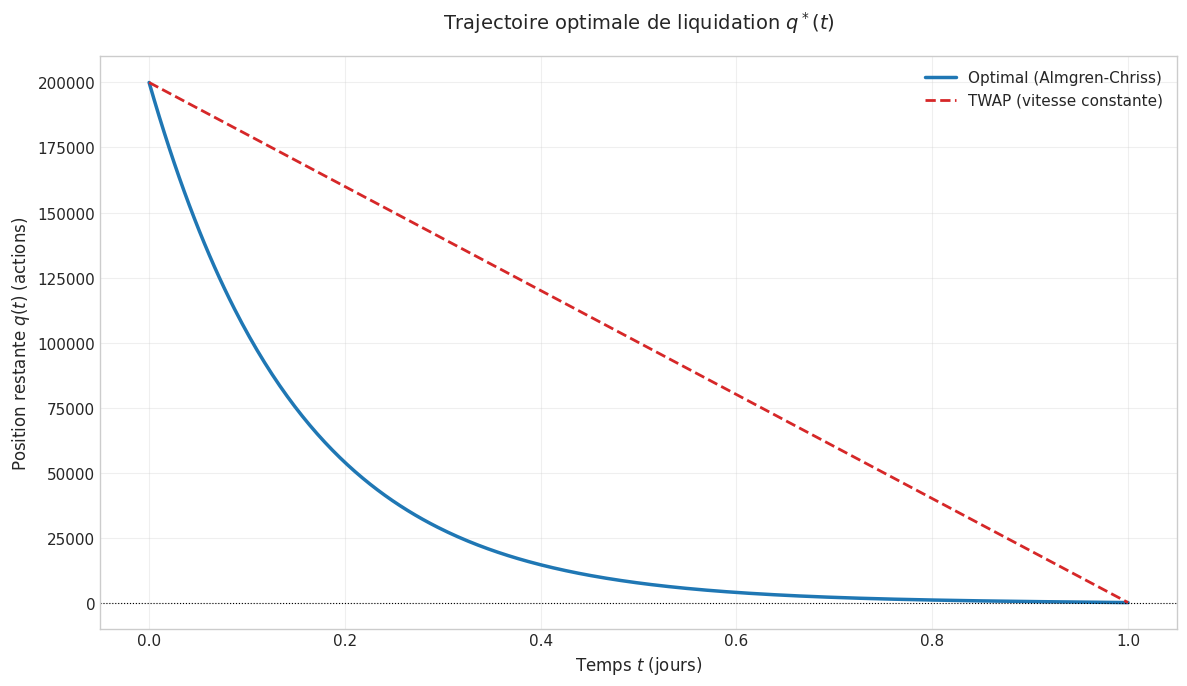

In [8]:
### Graphique 1 : Trajectoire de liquidation $ q^*(t) $ vs TWAP
plt.figure(figsize=(12, 7))

# Optimal
plt.plot(t_opt, q_opt, label='Optimal (Almgren-Chriss)', color='tab:blue', linewidth=2.5)

# TWAP
plt.plot(t_twap, q_twap, label='TWAP (vitesse constante)', color='tab:red', linestyle='--', linewidth=2)

plt.axhline(0, color='black', linewidth=0.8, linestyle=':')
plt.title(r'Trajectoire optimale de liquidation $q^*(t)$', fontsize=14, pad=20)
plt.xlabel('Temps $t$ (jours)', fontsize=12)
plt.ylabel('Position restante $q(t)$ (actions)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

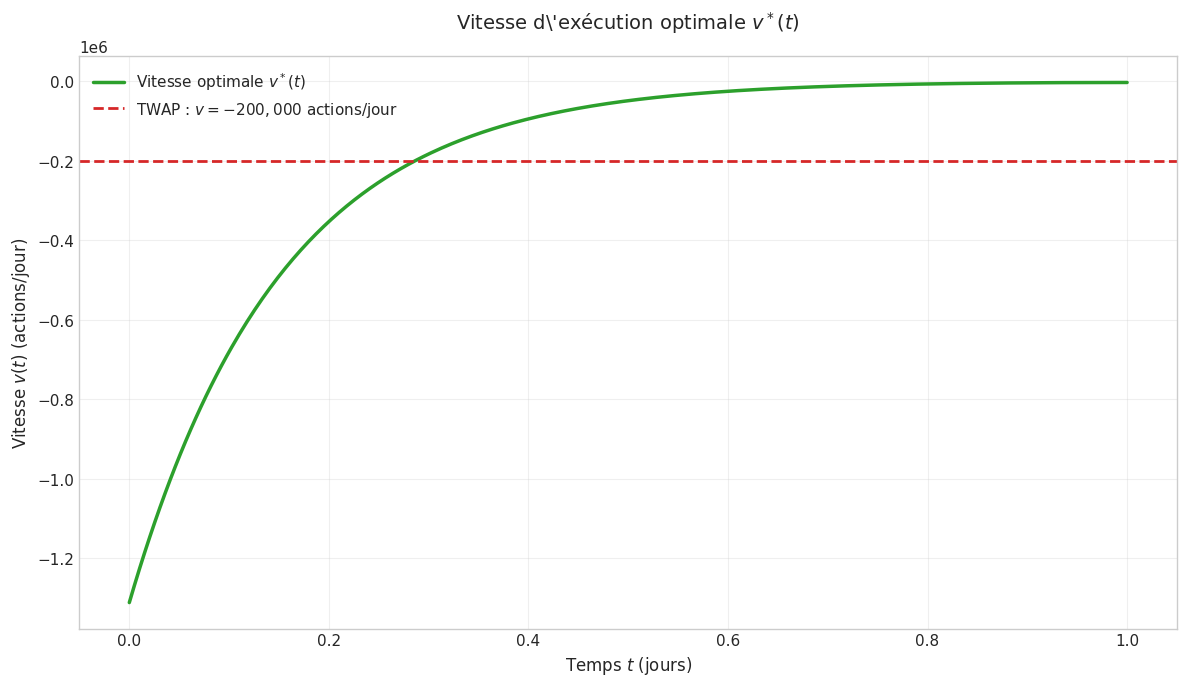

In [9]:
### Graphique 2 : Vitesse d’exécution optimale $ v^*(t) = \dot{q}^*(t) $
plt.figure(figsize=(12, 7))

# Vitesse optimale
plt.plot(t_opt, v_opt, label='Vitesse optimale $v^*(t)$', color='tab:green', linewidth=2.5)

# TWAP (constante)
plt.axhline(v_twap[0], color='tab:red', linestyle='--', linewidth=2, label=f'TWAP : $v = {v_twap[0]:,.0f}$ actions/jour')

plt.title(r'Vitesse d\'exécution optimale $v^*(t)$', fontsize=14, pad=20)
plt.xlabel('Temps $t$ (jours)', fontsize=12)
plt.ylabel('Vitesse $v(t)$ (actions/jour)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
## 3. Comparaison des coûts : Optimal vs TWAP
# Calcul des coûts
costs_opt = model.compute_costs(q0, T, 'optimal')
costs_twap = model.compute_costs(q0, T, 'twap')

# DataFrame pour affichage
df_costs = pd.DataFrame({
    'Optimal': costs_opt,
    'TWAP': costs_twap
}).T

df_costs['total_cost'] = df_costs[['execution_cost', 'permanent_impact', 'timing_risk']].sum(axis=1)

# Affichage
print("Coûts décomposés (en unités de prix × actions) :")
display(df_costs.round(6))

# Shortfall en € et bps
shortfall_opt = model.compute_expected_shortfall(q0, T, S0)
shortfall_twap = model.compute_expected_shortfall(q0, T, S0)  # même fonction, mais TWAP via compute_costs

print(f"\nImplementation Shortfall (Optimal) :")
print(f"   → {shortfall_opt['shortfall_euros']:,.0f} €")
print(f"   → {shortfall_opt['shortfall_bps']:.1f} bps du notionnel")

print(f"\nGain de l'optimal vs TWAP :")
gain_euros = (costs_twap['total_cost'] - costs_opt['total_cost']) * S0
gain_bps = (gain_euros / (q0 * S0)) * 10000
print(f"   → {gain_euros:,.0f} € ({gain_bps:.1f} bps)")

Coûts décomposés (en unités de prix × actions) :


,execution_cost,permanent_impact,timing_risk,timing_risk_variance,total_cost
Optimal,0.000115,250.0,1236.298656,4.945195e+08,1486.298770
TWAP,0.000034,250.0,5333.418152,2.133367e+09,5583.418187



Implementation Shortfall (Optimal) :
   → 298,895 €
   → 74.3 bps du notionnel

Gain de l'optimal vs TWAP :
   → 823,931 € (204.9 bps)


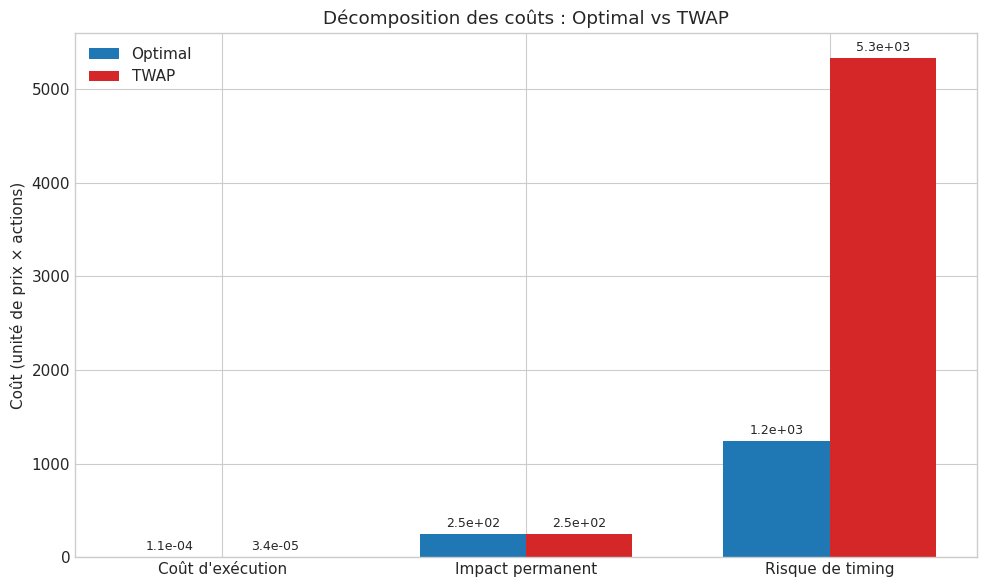

In [11]:
### Graphique 3 : Décomposition des coûts (Optimal vs TWAP)
components = ['execution_cost', 'permanent_impact', 'timing_risk']
labels = ['Coût d\'exécution', 'Impact permanent', 'Risque de timing']

x = np.arange(len(components))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, [costs_opt[c] for c in components], width, label='Optimal', color='tab:blue')
bars2 = ax.bar(x + width/2, [costs_twap[c] for c in components], width, label='TWAP', color='tab:red')

ax.set_ylabel('Coût (unité de prix × actions)')
ax.set_title('Décomposition des coûts : Optimal vs TWAP')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Ajouter les valeurs sur les barres
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1e}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

autolabel(bars1)
autolabel(bars2)

plt.tight_layout()
plt.show()

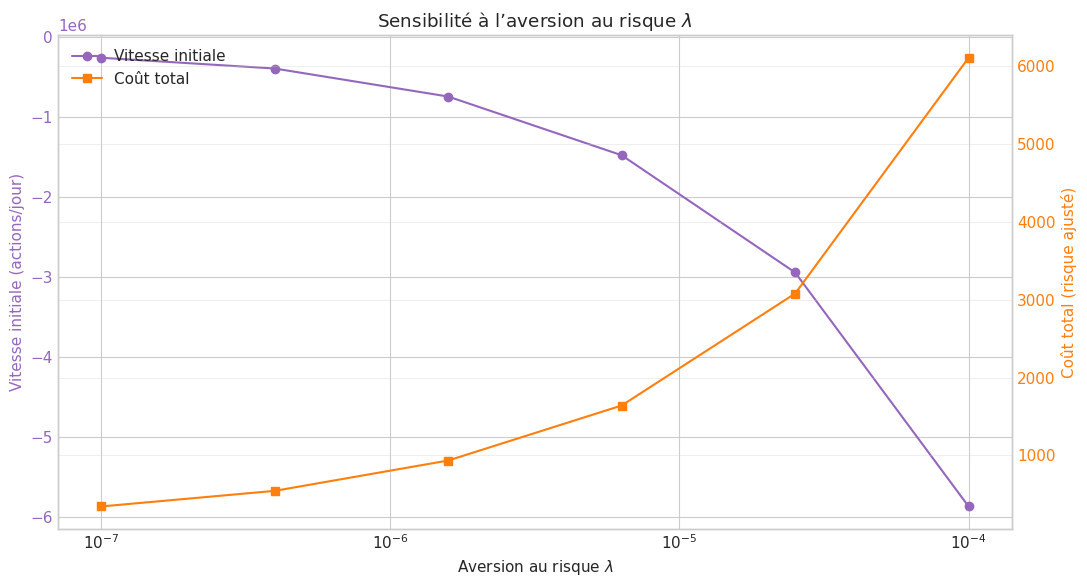

,λ,κ,v_initial,execution_cost,timing_risk,total_cost
0,0.000000,0.926996,-2.542535e+05,0.000035,95.833824,345.833859
1,0.000000,1.849600,-3.886906e+05,0.000040,296.076419,546.076459
2,0.000002,3.690437,-7.390078e+05,0.000065,685.558753,935.558817
3,0.000006,7.363391,-1.472679e+06,0.000129,1391.712912,1641.713041
4,0.000025,14.691896,-2.938379e+06,0.000262,2829.034806,3079.035068
5,0.000100,29.314186,-5.862837e+06,0.000543,5856.190145,6106.190688


In [12]:
## 4. Sensibilité à l’aversion au risque $ \lambda $
lambdas = np.logspace(-7, -4, 6)  # de 1e-7 à 1e-4
results = []

for lam in lambdas:
    model_temp = AlmgrenChrissQuadratic(lam, sigma, b, eta, V)
    t, q, v = model_temp.optimal_trajectory(q0, T)
    costs = model_temp.compute_costs(q0, T, 'optimal')
    results.append({
        'λ': lam,
        'κ': model_temp.compute_kappa(),
        'v_initial': v[0],
        'execution_cost': costs['execution_cost'],
        'timing_risk': costs['timing_risk'],
        'total_cost': costs['total_cost']
    })

df_sens = pd.DataFrame(results)

# Graphique
fig, ax1 = plt.subplots(figsize=(11, 6))

ax1.plot(df_sens['λ'], df_sens['v_initial'], 'o-', color='tab:purple', label='Vitesse initiale')
ax1.set_xlabel('Aversion au risque $ \\lambda $')
ax1.set_ylabel('Vitesse initiale (actions/jour)', color='tab:purple')
ax1.tick_params(axis='y', labelcolor='tab:purple')
ax1.set_xscale('log')

ax2 = ax1.twinx()
ax2.plot(df_sens['λ'], df_sens['total_cost'], 's-', color='tab:orange', label='Coût total')
ax2.set_ylabel('Coût total (risque ajusté)', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Sensibilité à l’aversion au risque $ \\lambda $')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

display(df_sens.round(6))

In [13]:
# Sauvegarde
results_dict = {
    'parameters': params,
    'trajectory': {'t': t_opt.tolist(), 'q': q_opt.tolist(), 'v': v_opt.tolist()},
    'costs_optimal': costs_opt,
    'costs_twap': costs_twap,
    'shortfall_optimal': shortfall_opt,
    'sensitivity': df_sens.to_dict('records')
}

with open('results/almgren_chriss_quadratic_results.json', 'w') as f:
    json.dump(results_dict, f, indent=2, default=float)

print("Résultats sauvegardés dans 'results/almgren_chriss_quadratic_results.json'")

Résultats sauvegardés dans 'results/almgren_chriss_quadratic_results.json'
